<a href="https://colab.research.google.com/github/cbevis/2015lab1/blob/master/Capstone_Neural_Net_Copy5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 311 Neural Networks 

Rev5 Notes:
Fit generator
For combined model - three channels to VGG, one channel to cnn

Rev4 Notes:
Implementing a trained model
-VGG16
- Use 60000 datapoints for memory, 

Rev3 Notes:
- Added more layers to CNN, additional dropout
- Increased batch size
- Current accuracy at 51%


Rev2 Notes: 
 - Removed MLP on images - CNN is the way to go
 - Added layer on combined and changed filter size to 64

### References:
- Convert to grayscale: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/12201744#12201744
- Keras early stopping: https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
- Grayscale Keras: https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/
- Combining models: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
- Neighborhoods geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4
- Plotting in folium: https://towardsdatascience.com/visualizing-data-at-the-zip-code-level-with-folium-d07ac983db2
- Using a pretrained network: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import keras
import glob
from numpy import random
from PIL import Image

# Import Components for model building
# Import various components for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate, Input
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

# Import the backend
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy import interp
from itertools import cycle, compress

% matplotlib inline

In [3]:
# Check for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:

!ls "/content/drive/My Drive/Colab Notebooks"

 311-Capstone-Neural-Net-Copy1.ipynb   bw_pickles
 311-Capstone-Neural-Net-Copy2.ipynb   Capstone-Neural-Net-Copy5.ipynb
 311-Capstone-Neural-Net-Copy3.ipynb  'Copy of Capstone-Neural-Net-Copy5.ipynb'
 311-Capstone-Neural-Net-Copy4.ipynb   Untitled0.ipynb


In [11]:
# Using grayscale 128 x 128 images from 2017 and 2018
# Limited due to computational time and disc space
data_path = '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_[0-9]*.gzde'
files = glob.glob(data_path)
print(files)
# Sort for repeatability
files = sorted(files)
dim1, dim2, dim3 = 128, 128, 1

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns

# Drop files without an image
df.dropna(subset=['image'], inplace=True)
df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['month'] = df['month'].astype('int16')
df['year'] = df['year'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['police_district'] = df['police_district'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['status'] = df['status'].astype('category')
df['responsible_agency'] = df['responsible_agency'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')  

['/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_19000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_26000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_36000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_2000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_44000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_54000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_107000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_117000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_62000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_72000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_10000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_86000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_96000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pickles/bw_73000.gzde', '/content/drive/My Drive/Colab Notebooks/bw_pi

In [0]:
# Clear up some memory, don't end up using these columns
drop_cols = ['closed', 'updated', 'status', 'status_notes', 'image', 
             'address', 'supervisor_district', 'latitude', 'longitude', 'point', 
             'source', 'media_url', 'year', 'responsible_agency',
             'request_details', 'police_district']

In [0]:
df.reset_index(inplace=True, drop=True)
X_flat = np.concatenate(df.image.values.tolist(), axis=0)
X_flat = X_flat.reshape(df.shape[0], dim1*dim2*dim3) 
df.drop(columns=drop_cols, inplace=True)


In [14]:
# Check the shape
X_flat.shape

(148076, 16384)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148076 entries, 0 to 148075
Data columns (total 8 columns):
caseid             148076 non-null int64
opened             148076 non-null datetime64[ns]
category           148076 non-null category
request_type       148076 non-null object
street             148076 non-null object
neighborhood       148076 non-null object
police_district    147742 non-null category
month              148076 non-null int16
dtypes: category(2), datetime64[ns](1), int16(1), int64(1), object(3)
memory usage: 6.2+ MB


In [16]:
df.head(2)

,caseid,opened,category,request_type,street,neighborhood,police_district,month
0,7228536,2017-06-06 07:31:38,Graffiti,Graffiti on Signal_box,6TH ST,South of Market,SOUTHERN,6
1,9848318,2018-11-25 13:15:00,Parking Enforcement,Other_Illegal_Parking,TAYLOR ST,Tenderloin,TENDERLOIN,11


## Reduce Categories
The following function reduces the number of categories to 16.  It uses the category and request type columns to create new columns.  Smaller categories that sounded like images might be similar are grouped together.  For example,  "Abandoned Vehicle" and "Parking Enforcement" are grouped together because they both are likely images of vehicles.   

In [0]:
# Function to group items together into 16 categories
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

In [18]:
# Apply categorization
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Graffiti' 'Vehicle' 'General Cleaning' 'Litter Receptacles'
 'Hazardous Materials' 'Street and Sidewalk Issues'
 'Rec and Park Requests' 'Bulky Items' 'Encampments'
 'Human or Medical Waste' 'Other' 'Signs - Illegal Postings and Repair'
 'Tree Maintenance' 'Sewer Issues' 'Streetlights' 'Damaged Property']
16


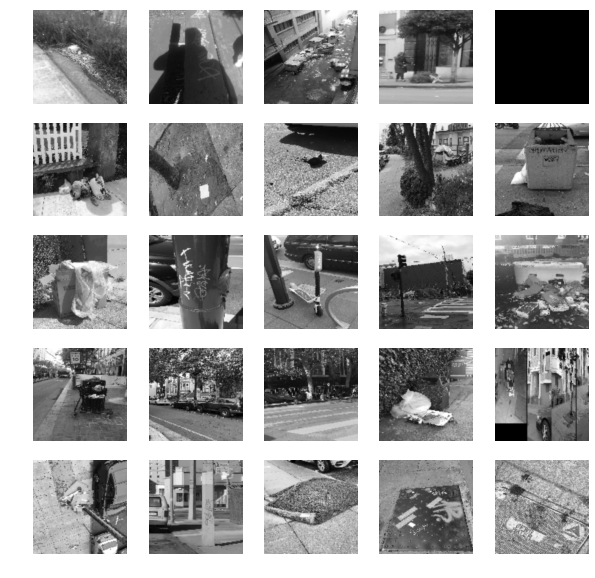

In [19]:
# Visualizing dataset
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_flat)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_flat[i:i+1][0].reshape(128, 128),
                           cmap='gray',
                           interpolation='gaussian')        

# Variables

This splits the image data, the categorical data, and the outputs into training sets and test sets.  The output data is label encoded.  Since a pretrained network is used, the image data will have 3 channels, but they will all be identical since they are grayscale images.  A variance threshold of 0.9995 is used to remove one hot encoded categorical features that are 0 or 1 in the majority of the samples.  This eliminates about half of the categorical features and helps to prevent overfitting.  SelectKBest was also tried to further reduce the feature space, but it made the performance of the model worse and did not significantly improve the modeling speed.

In [27]:
rand_state = 38
features = ['month', 'neighborhood', 'street']
dim1, dim2, dim3 = 128, 128, 3
# Need to use 3 channels if using vgg
input_shape = (dim1, dim2, dim3)
num_classes = 16

# Label encode labels
X_train, X_test, y_train, y_test = train_test_split(X_flat, 
                                                    df['group'], 
                                                    test_size=0.25,
                                                    random_state=rand_state)

# Out put data label encoded
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train = keras.utils.to_categorical(y_train_enc, 16)
y_test = keras.utils.to_categorical(y_test_enc, 16)

print('Overall shape:')
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Select features and one hot encode
X_cat = df[features]
ohe = OneHotEncoder()
X_cat = ohe.fit_transform(X_cat)
print('\nCategorical Variable:')
print(X_cat.shape[1], 'Features after One Hot Encoding')

# Need to use same random_state as before to make sure that the image data
# and the categorical data are still aligned
X_cat_train, X_cat_test = train_test_split(X_cat, 
                                           test_size=0.25,
                                           random_state=rand_state)

# Select features with variance threshold of 99.95%
# 1 or 0 in more than 99.95% of samples
sel = VarianceThreshold(threshold=(.9995*(1-.9995)))
X_sel_train = sel.fit_transform(X_cat_train)
X_sel_test = sel.transform(X_cat_test)
print(X_sel_train.shape[1], 'Features after variance threshold')

# Select K Best Features - didn't help
# k_num = X_sel_train.shape[1]
# sel_k = SelectKBest(chi2, k=k_num)
# X_sel_k = sel_k.fit_transform(X_sel_train, y_train)
# X_sel_k_test = sel_k.transform(X_sel_test)
# print('X_train Select K Best, K={}: {}'.format(k_num, X_sel_k.shape))


Overall shape
111057 train samples
37019 test samples

Categorical Variable:
2136 Features after One Hot Encoding
462 Features after variance threshold


# Plotting Functions

In [0]:
def plot_rocs(y_score):
  #n_classes = num_classes
  # Line width
  lw = 2

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

  # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(num_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= num_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr['micro'], tpr['micro'],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['micro']),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr['macro'], tpr['macro'],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['macro']),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple', 'green', 
                  'blue', 'pink', 'brown', 'red', 'teal', 'orange', 'lime',
                  'magenta', 'yellow', 'grey', 'olive', 'bright purple', 'cyan',
                  'lavender'])

  for i, color in zip(range(num_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
               label='ROC curve of {0} (area = {1:0.2f})'.format(i, roc_auc[i]))


  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC CNN')
  # Put a legend to the right of the current axis
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

  for i in range(0, num_classes):
    print('{}: {}'.format(i, le.inverse_transform([i])[0]))

In [0]:
def plot_loss(acc, val_acc, loss, val_loss):
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Generators

## Generator to convert to 3 channel grayscale. 
This is used for VGG or other pretrained models on RGB.

In [0]:
# This generator is for converting the images to 3 channel grayscale images
def generator(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  while True:
    
    batch_features = np.zeros((batch_size, 128, 128))
    batch_labels = np.zeros((batch_size, 16))
  
    for i in range(batch_size):
      # Choose random index in features
      # Some indexes will be repeated, but over the size of the dataset
      # This will likely not cause severe overfitting
      # Could make a Sequence object to only use once if bothered.
      index = random.choice(len(features),1)
      sample = features[index]
      sample = sample.reshape(128, 128)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.astype('float32')
    batch_features /=255
    yield batch_features, batch_labels
    
# This generator creates the validation data set for the 3 channel grayscale 
# images.  
def val_generator(features, labels, batch_size):

  samples_per_epoch = features.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter = 0

  while True:

    # For validation, need to be sure each image is viewed once
    # Can index in order because we are not training
    index_list = range(batch_size*counter, 
                       min(batch_size*(counter+1), features.shape[0]))
    batch_features = np.array(features[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128)
    # Triplicate gray scale on all three axis
    batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    # Scale values
    batch_features /=255
    batch_labels = np.array(labels[index_list])
    
    counter += 1
    yield batch_features, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

## Generator to combine 3 models
For example, cnn, vgg16, and mlp data inputs.  Need to make image data 3 channels

In [0]:
# This generator is used for combing 
def generator_three(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  features_cnn, features_mlp = features

  while True:
    
    batch_features = np.zeros((batch_size, 128, 128))
    batch_labels = np.zeros((batch_size, 16))
    index_list = []
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(features_cnn.shape[0])
      index_list.append(index)
      sample = features_cnn[index]
      sample = sample.reshape(128, 128)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    batch_features = batch_features.astype('float32')
    batch_features /=255
    
    # Three channels for pseudo RGB, 1 channel for CNN
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.reshape(batch_size, 128, 128, 1)
    
    # fit_generator does not accept sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
    
    yield [batch_features, batch_features3, batch_mlp], batch_labels
    

# size = batch_size for val_generator_three    
def val_generator_three(features, labels, size):
  
  features_cnn, features_mlp = features
  samples_per_epoch = features_cnn.shape[0]
  number_of_batches = samples_per_epoch/size
  counter = 0

  while True:
    index_list = range(size*counter, 
                       min(size*(counter+1), features_cnn.shape[0]))
    
    batch_features = np.array(features_cnn[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128)
    batch_features /=255
    
    # Three channels for pseudo rgb, 1 channel for not
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128, 1)
  
    batch_labels = np.array(labels[index_list])
    
    # Fit_generator doesn't like sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
                              
      
    counter += 1
    yield [batch_features, batch_features3, batch_mlp], batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

## Generator to combine VGG and categorical

In [0]:
# This generator is used for combing 
def generator_two(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  features_vgg, features_mlp = features

  while True:
    
    batch_features = np.zeros((batch_size, 128, 128))
    batch_labels = np.zeros((batch_size, 16))
    index_list = []
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(features_vgg.shape[0])
      index_list.append(index)
      sample = features_vgg[index]
      sample = sample.reshape(128, 128)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    print('here4')
    batch_features = batch_features.astype('float32')
    batch_features /=255
    
    # Three channels for pseudo RGB, 1 channel for CNN
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    
    # fit_generator does not accept sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
    print('here1')
    yield [batch_features3, batch_mlp], batch_labels
    

# size = batch_size for val_generator_three    
def val_generator_two(features, labels, size):
  print('here2')
  features_vgg, features_mlp = features
  
  samples_per_epoch = features_vgg.shape[0]
  number_of_batches = samples_per_epoch/size
  counter = 0

  while True:
    index_list = range(size*counter, 
                       min(size*(counter+1), features_vgg.shape[0]))
    
    batch_features = np.array(features_vgg[index_list])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128)
    batch_features /=255
    
    # Three channels for pseudo rgb, 1 channel for not
    batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features3 = batch_features3.reshape(batch_features3.shape[0], 128, 128, 3)
  
    batch_labels = np.array(labels[index_list])
    
    # Fit_generator doesn't like sparse matrices
    batch_mlp = np.array(features_mlp[index_list].todense())
                              
      
    counter += 1
    yield [batch_features3, batch_mlp], batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

# Unify Generators

In [0]:
# This generator is used for combing 
def generator_all(features, 
                  labels, 
                  batch_size, 
                  one_chan=True, 
                  three_chan=True, 
                  categoricals=True):
  
  if (one_chan or three_chan) and categoricals: 
    features_image, features_cat = features
    train_size = features_image[0]
  
  elif (one_chan or three_chan):
    features_image = features
  
  else:
    features_cat = features
    train_size = features_cat.shape[0]

  while True:
    if one_chan or three_chan:
      batch_features = np.zeros((batch_size, 128, 128))
    batch_labels = np.zeros((batch_size, 16))
    index_list = []
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(train_size)
      index_list.append(index)
      if one_chan or three_chan:
        sample = features_image[index]
        sample = sample.reshape(128, 128)
        batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    if one_chan or three_chan:
      batch_features = batch_features.astype('float32')
      batch_features /=255
    
    # Three channels for pseudo RGB, 1 channel for CNN
    if three_chan:
      batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    if one_chan:
      batch_features = batch_features.reshape(batch_size, 128, 128, 1)
    
    # fit_generator does not accept sparse matrices
    if categoricals:
      batch_mlp = np.array(features_cat[index_list].todense())
    
    yield_data = []
    if one_chan == True:
      yield_data.append(batch_features)
    if three_chan == True:
      yield_data.append(batch_features3)
    if categoricals == True:
      yield_data.append(batch_mlp)
      
    yield yield_data, batch_labels
      
  
  else:
    features_cat = features
    train_size = features_cat.shape[0]
    yield [batch_features, batch_features3, batch_mlp], batch_labels
    

# size = batch_size for val_generator_three    
def val_generator_all(features, 
                      labels, 
                      size,
                      one_chan=True, 
                      three_chan=True, 
                      categoricals=True):
  
  if (one_chan or three_chan) and categoricals: 
    features_image, features_cat = features
    samples_per_epoch = features_image[0]
  
  elif (one_chan or three_chan):
    features_image = features
  
  else:
    features_cat = features
    samples_per_epoch = features_cat.shape[0]
    
  number_of_batches = samples_per_epoch/size
  counter = 0

  while True:
    index_list = range(size*counter, 
                       min(size*(counter+1), samples_per_epoch))
    
    if (one_chan or three_chan):
      batch_features = np.array(features_image[index_list])
      batch_features = batch_features.astype('float32')
      batch_features = batch_features.reshape(batch_features.shape[0], 128, 128)
      batch_features /=255
    
    if three_chan:
    # Three channels for pseudo rgb, 1 channel for not
      batch_features3 = np.repeat(batch_features[..., np.newaxis], 3, -1)
    
    if one_chan:
      batch_features = batch_features.reshape(size, 128, 128, 1)
  
    batch_labels = np.array(labels[index_list])
    
    if categoricals:
      # Fit_generator doesn't like sparse matrices
      batch_mlp = np.array(features_mlp[index_list].todense())
                              
      
    counter += 1
    
    yield_data = []
    if one_chan == True:
      yield_data.append(batch_features)
    if three_chan == True:
      yield_data.append(batch_features3)
    if categoricals == True:
      yield_data.append(batch_mlp)
      
    yield yield_data, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

In [42]:
one = [3, 4, 5]
two = [1, 0, 1]

list(compress(one, two))

[3, 5]

## Generator CNN only

In [0]:
# No need to triplicate axis if not using with VGG, etc
def generator_cnn(features, labels, batch_size):
 # Create empty arrays to contain batch of features and labels#

  while True:
    
    batch_features = np.zeros((batch_size, 128, 128, 1))
    batch_labels = np.zeros((batch_size, 16))
  
    for i in range(batch_size):
      # choose random index in features
      index = random.choice(len(features),1)
      sample = features[index]
      sample = sample.reshape(128, 128, 1)
      
      #print(features[index].shape)
      batch_features[i] = sample
      batch_labels[i] = labels[index]
    
    #batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features = batch_features.astype('float32')
    batch_features /=255
    yield batch_features, batch_labels
    
def val_generator_cnn(features, labels, batch_size):

  samples_per_epoch = features.shape[0]
  number_of_batches = samples_per_epoch/batch_size
  counter = 0

  while True:

    batch_features = np.array(features[batch_size*counter:min(batch_size*(counter+1), 
                                                              features.shape[0])])
    batch_features = batch_features.astype('float32')
    batch_features = batch_features.reshape(batch_features.shape[0], 128, 128, 1)
    #batch_features = np.repeat(batch_features[..., np.newaxis], 3, -1)
    batch_features /=255
    
    batch_labels = np.array(labels[batch_size*counter:min(batch_size*(counter+1), 
                                                          features.shape[0])])
    counter += 1
    yield batch_features, batch_labels

    #restart counter to yeild data in the next epoch as well
    if counter >= number_of_batches:
        counter = 0

# Convolutional Neural Network
- Black and White 128x128 images

Model performs much worse if filters set to 64, 128, 256

In [0]:
input_shape_cnn = (128, 128, 1)

inputs = Input(shape=input_shape_cnn)
chan_dim = -1

x1 = Conv2D(32, (3, 3), padding='same')(inputs)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(32, (3, 3), padding='same')(inputs)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.25)(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(128, (3, 3), padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = BatchNormalization(axis=chan_dim)(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)
x1 = Dense(num_classes)(x1)
x1 = Activation('softmax')(x1)

cnn = Model(inputs, x1)

In [0]:
cnn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_cnn.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

# For running cnn independently - don't need to triplicate axis
input_shape = (128, 128, 1)

# fits the model on batches with real-time data augmentation:
history_cnn = cnn.fit_generator(generator_cnn(X_train, y_train, 256), 
                                steps_per_epoch=351,
                                verbose=1,
                                epochs=10,
                                validation_data=val_generator_cnn(X_test, y_test, 32),
                                validation_steps=X_test.shape[0]/32,
                                callbacks=callbacks)

y_score_cnn = cnn.predict_generator(val_generator_cnn(X_test, y_test, 32),
                                    steps=X_test.shape[0]/32)


Epoch 1/10
351/351 [==============================] - 90s 257ms/step - loss: 2.3870 - acc: 0.2896 - val_loss: 2.1445 - val_acc: 0.3265
Epoch 2/10
351/351 [==============================] - 85s 242ms/step - loss: 1.9903 - acc: 0.3865 - val_loss: 1.9404 - val_acc: 0.4020
Epoch 3/10
351/351 [==============================] - 85s 242ms/step - loss: 1.8757 - acc: 0.4243 - val_loss: 1.8411 - val_acc: 0.4352
Epoch 4/10
351/351 [==============================] - 85s 242ms/step - loss: 1.7907 - acc: 0.4524 - val_loss: 1.7937 - val_acc: 0.4491
Epoch 5/10
  7/351 [..............................] - ETA: 1:12 - loss: 1.7689 - acc: 0.4526

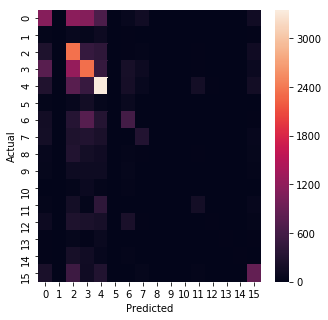

In [0]:
plot_rocs(y_score_cnn)

In [0]:
acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

# VGG

In [63]:
vgg_conv = VGG16(weights='imagenet', include_top=False)


# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

    # This returns a tensor
inputs = Input(shape=input_shape)
chan_dim = -1

# Add VCG layer on top
x2 = vgg_conv(inputs)

x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)
x2 = Dense(num_classes)(x2)
x2 = Activation('softmax')(x2)

vgg = Model(inputs, x2)

<keras.engine.input_layer.InputLayer object at 0x7fbe007cabe0> False
<keras.layers.convolutional.Conv2D object at 0x7fbe007a6d68> False
<keras.layers.convolutional.Conv2D object at 0x7fbe007cae10> False
<keras.layers.pooling.MaxPooling2D object at 0x7fbe000362e8> False
<keras.layers.convolutional.Conv2D object at 0x7fbde7eddef0> False
<keras.layers.convolutional.Conv2D object at 0x7fbe0004fef0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fbdebed3668> False
<keras.layers.convolutional.Conv2D object at 0x7fbdebed3198> False
<keras.layers.convolutional.Conv2D object at 0x7fbdea284320> False
<keras.layers.convolutional.Conv2D object at 0x7fbdea29c940> False
<keras.layers.pooling.MaxPooling2D object at 0x7fbdea2b3fd0> False
<keras.layers.convolutional.Conv2D object at 0x7fbdea2b3978> False
<keras.layers.convolutional.Conv2D object at 0x7fbde9be1c18> False
<keras.layers.convolutional.Conv2D object at 0x7fbde9bf9c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7fbde8525c18>

In [65]:
vgg.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adadelta(),
            metrics=['accuracy'])

# Set callback functions to early stop training and save 
# the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint(filepath='best_model_cnn.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]


# fits the model on batches with real-time data augmentation:
history_vgg = vgg.fit_generator(generator(X_train, y_train, 256), 
                                steps_per_epoch=351,
                                verbose=1,
                                epochs=10,
                                validation_data=val_generator(X_test, y_test, 32),
                                validation_steps=X_test.shape[0]/32,
                                callbacks=callbacks)


y_score_vgg = vgg.predict_generator(val_generator(X_test, y_test, 32),
                                    steps=X_test.shape[0]/32)


Epoch 1/10
351/351 [==============================] - 216s 615ms/step - loss: 0.5234 - acc: 0.8366 - val_loss: 2.5021 - val_acc: 0.5090
Epoch 2/10
351/351 [==============================] - 213s 606ms/step - loss: 0.4574 - acc: 0.8597 - val_loss: 2.5103 - val_acc: 0.5064
Epoch 3/10
351/351 [==============================] - 223s 635ms/step - loss: 0.4032 - acc: 0.8758 - val_loss: 2.7675 - val_acc: 0.5091
Epoch 4/10
351/351 [==============================] - 268s 763ms/step - loss: 0.3705 - acc: 0.8871 - val_loss: 2.7082 - val_acc: 0.5048
Epoch 5/10
351/351 [==============================] - 213s 607ms/step - loss: 0.3465 - acc: 0.8938 - val_loss: 3.0062 - val_acc: 0.5095


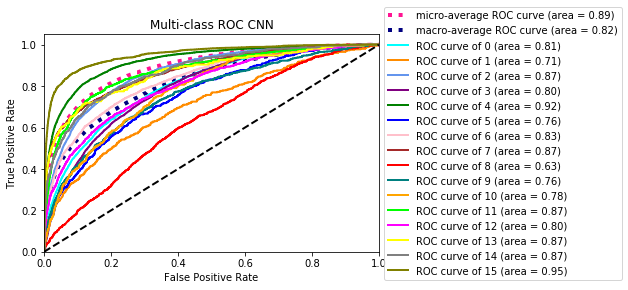

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [67]:
plot_rocs(y_score_vgg)

In [69]:
acc = history_vgg.history['acc']
val_acc = history_vgg.history['val_acc']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

NameError: ignored

# MLP

In [0]:
# MLP model for categorical variables
input_shape_cat = X_sel_train.shape[1]

# This returns a tensor
inputs = Input(shape=(input_shape_cat,))

# a layer instance is callable on a tensor and returns a tensor
x = Dense(128, activation='relu')(inputs)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# This creates a model that includes
# the Input layer and three Dense layers
mlp = Model(inputs=inputs, outputs=predictions)

In [72]:
mlp.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_cat.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history_mlp = mlp.fit(X_sel_train, y_train,
                      batch_size=128,
                      epochs=20,
                      verbose=1,
                      callbacks=callbacks,
                      validation_data=(X_sel_test, y_test))
score_mlp = mlp.evaluate(X_sel_test, y_test, verbose=0)
y_score_mlp = mlp.predict(X_sel_test)

print('Test loss:', score_mlp[0])
print('Test accuracy:', score_mlp[1])

Train on 111057 samples, validate on 37019 samples
Epoch 1/20
111057/111057 [==============================] - 6s 52us/step - loss: 2.0054 - acc: 0.3371 - val_loss: 2.0516 - val_acc: 0.3214
Epoch 2/20
111057/111057 [==============================] - 4s 34us/step - loss: 2.0028 - acc: 0.3388 - val_loss: 2.0483 - val_acc: 0.3212
Epoch 3/20
111057/111057 [==============================] - 4s 35us/step - loss: 1.9981 - acc: 0.3389 - val_loss: 2.0519 - val_acc: 0.3203
Epoch 4/20
111057/111057 [==============================] - 4s 35us/step - loss: 1.9931 - acc: 0.3399 - val_loss: 2.0485 - val_acc: 0.3206
Test loss: 2.048456809957319
Test accuracy: 0.32064615466847224


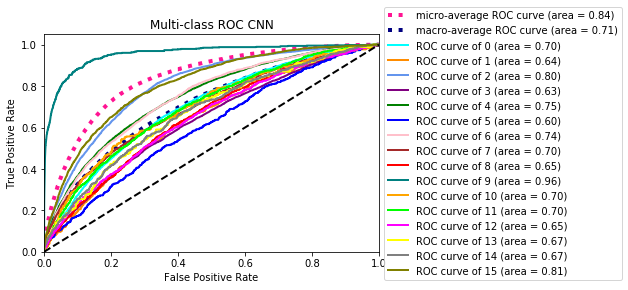

0: Bulky Items
1: Damaged Property
2: Encampments
3: General Cleaning
4: Graffiti
5: Hazardous Materials
6: Human or Medical Waste
7: Litter Receptacles
8: Other
9: Rec and Park Requests
10: Sewer Issues
11: Signs - Illegal Postings and Repair
12: Street and Sidewalk Issues
13: Streetlights
14: Tree Maintenance
15: Vehicle


In [73]:
plot_rocs(y_score_mlp)

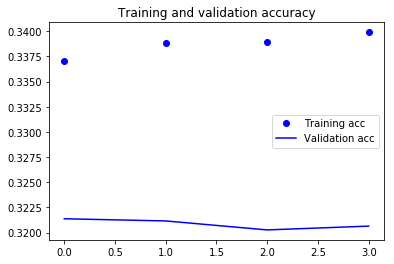

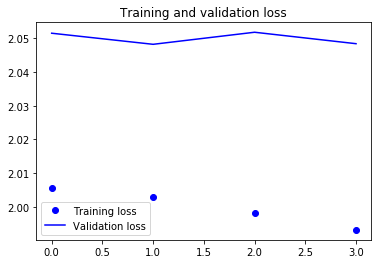

In [75]:
acc = history_mlp.history['acc']
val_acc = history_mlp.history['val_acc']
loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

plot_loss(acc, val_acc, loss, val_loss)

# Combine Models - All 3

In [49]:
# combine the output of previous two models
combined_input = concatenate([cnn.output, vgg.output, mlp.output])

# Final Fully Connected layer head, 2 dense layers
x3 = Dense(32, activation='relu')(combined_input)
x3 = Dropout(0.5)(x3)
x3 = Dense(64, activation='relu')(x3)
x3 = Dropout(0.5)(x3)
x3 = Dense(num_classes, activation='softmax')(x3)
                              
# Final model accepts input from both mlp and cnn
model = Model(inputs=[cnn.input, vgg.input, mlp.input], outputs=x3)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_all.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history = model.fit_generator(generator_three([X_train, X_sel_train], 
                                              y_train, 
                                              32),
                              steps_per_epoch=2800,
                              verbose=1,
                              validation_data=val_generator_three([X_test, X_sel_test], 
                                                                  y_test, 
                                                                  32),
                              validation_steps=X_test.shape[0]/32,
                              epochs=10,
                              callbacks=callbacks)


Epoch 1/10
2800/2800 [==============================] - 336s 120ms/step - loss: 2.2371 - acc: 0.2540 - val_loss: 2.1411 - val_acc: 0.3002
Epoch 2/10
2800/2800 [==============================] - 332s 118ms/step - loss: 2.1377 - acc: 0.3017 - val_loss: 2.0681 - val_acc: 0.3292
Epoch 3/10
2800/2800 [==============================] - 332s 118ms/step - loss: 2.1065 - acc: 0.3181 - val_loss: 2.0474 - val_acc: 0.3361
Epoch 4/10
 965/2800 [=========>....................] - ETA: 2:52 - loss: 2.0851 - acc: 0.3307

KeyboardInterrupt: ignored

In [0]:
from google.colab import files
files.download('best_model_all.h5')

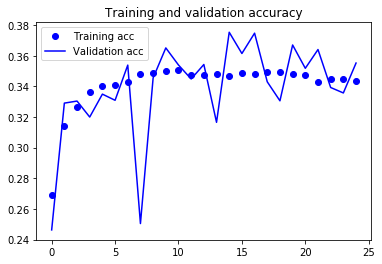

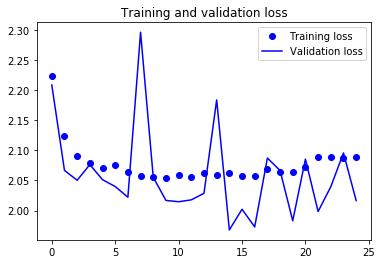

In [123]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## ROC Curves
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
Micro Average vs Macro Average: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. 

In [0]:
y_score = model.predict_generator(val_generator_three([X_test, X_sel_test], 
                                                       y_test, 
                                                       32),
                                  steps=X_test.shape[0]/32)

# Combine 2  VGG and categorical

In [56]:
# combine the output of previous two models
combined_input_2 = concatenate([vgg.output, mlp.output])

# Final Fully Connected layer head, 2 dense layers
x5 = Dense(32, activation='relu')(combined_input_2)
x5 = Dropout(0.5)(x5)
x5 = Dense(64, activation='relu')(x5)
x5 = Dropout(0.5)(x5)
x5 = Dense(16, activation='softmax')(x5)
                              
# Final model accepts input from both mlp and cnn
model_two = Model(inputs=[vgg.input, mlp.input], outputs=x5)

model_two.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_two.h5', 
                             monitor='val_loss', 
                             save_best_only=True)]

history_two = model.fit_generator(generator_all([X_train, X_sel_train], 
                                                y_train, 
                                                32,
                                                False,
                                                True,
                                                True),
                              steps_per_epoch=10,
                              verbose=1,
                              validation_data=val_generator_all([X_test, X_sel_test], 
                                                                 y_test, 
                                                                 32,
                                                                 False,
                                                                 True,
                                                                 True),
                              validation_steps=X_test.shape[0]/32,
                              epochs=10,
                              callbacks=callbacks)


Epoch 1/10
here2
here4
here1
here4
here1


ValueError: ignored